# LCCC Take Home Task : Simulating the Auction Process in the UK electricity market

In [43]:
import numpy as np
import pandas as pd
import openpyxl
openpyxl.__version__


'3.1.5'

## Importing data 

Importing the 7 sheets in the given excel file and taking a quick look to make sure everything has been read correctly or if I missed something in the data.

In [4]:
#reading the "windplants" table in the excel file and then taking a quick look at the dataframe to make sure the file was read correctly
wind_plants = pd.read_excel("data 2.xlsx", sheet_name="windplants")

wind_plants

,name,capacity
0,wind1,2500
1,wind2,3000
2,wind3,3500
3,wind4,4000
4,wind5,4500
5,wind6,5000


In [5]:
#the "windplants" import went fine, going ahead and importing the rest of the sheets on the excel file
wind_load = pd.read_excel("data 2.xlsx", sheet_name="wind_loadfactors")
solar_plants = pd.read_excel("data 2.xlsx", sheet_name="solarplants")
solar_load = pd.read_excel("data 2.xlsx", sheet_name="solar_loadfactors")
gas_plants = pd.read_excel("data 2.xlsx", sheet_name="gasplants")
demand = pd.read_excel("data 2.xlsx", sheet_name="demand")
gas_prices = pd.read_excel("data 2.xlsx", sheet_name="gas_prices")

 ## Precalculation

 Now that the data was imported, I wanted to think about the task ahead, simulating the auction. The initial idea I had: Calculate the effective capacity for the hour. Prioritise renewables to use up all of their effective capacity for the hour and then fill remaining demand using gas production. However, this means that the effective capacity would have to be calculated within the function. Since the entire dataset of load factors exists, it is more efficient to "precalculate" the entire dataframe of effective capacities for both renewables beforehand. 

$$
\text{Effective Capacity}_{i,t}^{\mathrm{ren}}
    =
\text{Maximum Capacity}_{i}^{\mathrm{ren}}
\cdot
\text{Load Factor}_{i,t}
$$

This is done in `effective_wind_cap = wind_lf.mul(wind,axis = 1)`for wind supply and done also for solar supply.

## Wind

In [6]:
# realigning indices of both dataframes before pandas multiplication
wind = wind_plants.set_index("name")["capacity"] 

wind_lf = wind_load.set_index("hour")


In [7]:
#pandas multiplication of wind capacities and loadfactors
effective_wind_cap = wind_lf.mul(wind,axis = 1)

#taking a look at the precalculated effective wind capacity 
effective_wind_cap.head(15)

,wind1,wind2,wind3,wind4,wind5,wind6
hour,,,,,,
1,65.718293,67.168387,1217.405330,1121.878619,886.793512,1261.672547
2,158.721493,151.756322,1184.981503,1459.682224,643.561606,998.968224
3,232.383588,207.782267,1346.058189,1684.266673,413.920812,714.178146
4,317.004745,295.675388,1454.667172,1724.460796,319.480719,492.593914
5,432.487628,459.214387,1478.763693,1612.310018,349.845178,389.172667
6,507.073758,572.648172,1534.310533,1619.999639,521.300452,483.539150
7,501.489124,606.520058,1483.991540,1304.625651,713.413763,625.294094
8,492.473758,643.872235,1423.039346,1408.052624,995.549191,914.115015
9,407.198365,568.502649,1573.548301,1831.943125,1125.462119,1071.903536


This now ensures that each hour of effective capacity is precalculated rather than calculated each hour in the loop of the auction function. Pandas multiplication is also vectorised so the process is much faster than looping. The same is done for solar below.

## Solar

In [8]:
# realigning indices
solar = solar_plants.set_index("name")["capacity"] 

solar_lf = solar_load.set_index("hour")

In [9]:
#pandas multiplication of solar capacities and loadfactors
effective_solar_cap = solar_lf.mul(solar,axis = 1)

#taking a look at the precalculated effective solar capacity 
effective_solar_cap.tail(15)

,solar1,solar2,solar3,solar4,solar5,solar6,solar7,solar8,solar9,solar10
hour,,,,,,,,,,
154,892.853483,956.945305,430.925837,1187.449583,830.986752,1452.757739,1423.860897,1682.356896,978.809297,1423.987270
155,1024.997033,1097.124602,659.691109,1237.534370,999.963719,1579.399324,1428.519200,1943.069604,1359.823550,1681.034880
156,1089.750935,1240.488586,1430.758258,1178.550618,1714.807178,1452.418318,1419.283608,2192.913871,2275.022919,1992.047070
157,1156.309492,1051.158956,1539.846352,1350.361678,1760.168013,1647.245724,1600.066265,2134.544708,2276.267461,2085.273541
158,965.965791,1150.600801,1591.002479,1529.369012,1719.940390,1857.535622,1829.497807,2185.379572,2471.798849,2211.212635
159,991.373445,1012.173082,1554.659336,1250.577618,1837.969353,1569.857835,1484.742889,1999.923248,2410.124875,2072.404253
160,805.968802,1093.117205,1201.377001,1364.818480,1687.150687,1702.571276,1571.873406,1906.523927,2090.830691,1903.228974
161,724.878016,931.918975,889.571021,1002.017004,1334.705031,1321.741400,1079.268008,1529.289394,1625.648519,1552.052609
162,663.590953,679.612163,687.762447,665.848170,973.494502,922.092540,679.869173,1125.771419,1238.964686,1225.455164


## GAS

Since gas is not dispatched at full capacity each hour, precalculating the capacity as done for renewables is not the correct approach. Each gas plant has its own capacity, and each hour has separate pricing. This does mean that the price can be precalculated for every hour in the dataset. The equation used to calculate the bid price (in £) for each gas plant at every hour is : 


$$
\text{Price Bid}_{i,t}^{\mathrm{gas}}
 =
\frac{Price_t^{\mathrm{gas}}}{100}
\cdot
\frac{34.121}{ efficiency_i}
$$

This is calculated and stored in the dataframe `gas_bid`.


In [44]:
#setting the therm per mwh constant as given in the task sheet
THERM_PER_MWH = 34.121

#converting pence to pounds
gp = gas_prices.set_index("hour")["price"] / 100.0         


#reindexing to prepare for calculation
eff = gas_plants.set_index("name")["efficiency"]             

#precalculating the gas bid price matrix 
gas_bid = pd.DataFrame(
    gp.to_numpy()[:, None] * (THERM_PER_MWH / eff.to_numpy()[None, :]),
    index=gp.index,
    columns=eff.index
)

In [11]:
#taking a look at the dataframe, did some manual calculations for a sanity check
gas_bid.head(20)

name,gas1,gas2,gas3,gas4,gas5
hour,,,,,
1,68.242000,59.711750,53.077111,47.76940,43.426727
2,70.191771,61.417800,54.593600,49.13424,44.667491
3,71.166657,62.270825,55.351844,49.81666,45.287873
4,70.191771,61.417800,54.593600,49.13424,44.667491
5,70.191771,61.417800,54.593600,49.13424,44.667491
6,73.116429,63.976875,56.868333,51.18150,46.528636
7,73.116429,63.976875,56.868333,51.18150,46.528636
8,76.041086,66.535950,59.143067,53.22876,48.389782
9,76.041086,66.535950,59.143067,53.22876,48.389782


In [13]:
#reindexing the gas capacity series
gas_cap = gas_plants.set_index("name")["capacity"]


name
gas1    2500
gas2    3000
gas3    3500
gas4    4000
gas5    4500
Name: capacity, dtype: int64

## Auction Sim

The auction logic is shown below. The auction function takes in all of the precalculated datasets to return the marginal prices for the hour, the dispatch series for each technology and the unserved demand by the hour. These are stored and returned as dictionaries which are converted into dataframes again once the function is called and results are acquired. Wind and solar bid £0/MWh as assumed in the task sheet. During certain hours renewable output exceeded demand. In this case I considered solutions to this. It would be inefficient to simply dispatch all renewable energy into the grid . The other solution was to fully dispatch the highest capacity renewable and then fill demand with the rest. But this creates a lopsided priority and real networks may not be equipped for this imbalance. I researched other methods and came across curtailment. Curtailment manages supply, specifically, pro rata curtailment, controls supply by finding the fraction of supply that the demand fulfills and then multiplies that fraction with the renewable supply. This is the form of curtailment used here and in real grids prevents network overload and supply imbalance.

<summary><b>Auction Logic : </b></summary>

1. Loop over each hour of the demand series.
2. Calculate total renewable output by adding the total capacities of solar and wind to get current availability.
3. Compare renewable availability to demand.
   - If renewables ≤ demand: dispatch all available wind + solar.
   - If renewables > demand: curtail pro rata (scale wind and solar down by the same factor so total renewable dispatch = demand).
   - Record per-plant wind/solar dispatch for the hour.
4. Compute residual demand: `leftover = demand - (wind_used + solar_used)`.
   - If residual demand ≤ 0: set price = £0/MWh, gas dispatch = 0, unserved = 0, move to next hour.
   - Otherwise, take the hour’s gas bids, sorted by ascending.
5. Dispatch gas plants in that order
   - For each plant: dispatch `min(plant_capacity, leftover)`, reduce `leftover`.
   - Track the marginal price as the bid of the last plant that actually generates.
   - Stop when leftover demand is met or gas capacity has run out.
6. Set the hour’s market price to the marginal accepted gas bid; set unserved demand to any leftover after all gas capacity is used.
7. Return hourly outputs: price, wind dispatch, solar dispatch, gas dispatch, unserved.

In [14]:
#reindexing the demand dataframe
demand = demand.set_index("hour")["demand"] 

In [16]:
def auction(demand_arr, eff_solar_cap, eff_wind_cap, gas_bid, gas_cap):
    """
    Clear an hourly electricity market using an auction.

    For each hour, available wind and solar generation is dispatched first at
    zero marginal cost. If total renewable availability exceeds demand, wind
    and solar output is curtailed proportionally. Any remaining demand is met
    by dispatching gas plants in ascending bid order up to their capacities.
    The market price is set by the marginal accepted gas bid. Unserved demand
    is recorded if total supply is insufficient.

    Parameters
    ----------
    demand_arr : pandas.Series
        Electricity demand per hour [MWh], indexed by hour.
    eff_solar_cap : pandas.DataFrame
        Effective (available) solar generation per plant and hour [MWh],
        indexed by hour with plant names as columns.
    eff_wind_cap : pandas.DataFrame
        Effective (available) wind generation per plant and hour [MWh],
        indexed by hour with plant names as columns.
    gas_bid : pandas.DataFrame
        Gas plant bid prices per hour [£/MWh], indexed by hour with plant
        names as columns.
    gas_cap : pandas.Series
        Maximum generation capacity of each gas plant [MW].

    Returns
    -------
    prices : dict
        Marginal electricity price per hour [£/MWh].
    wind_dispatch : dict
        Dispatched wind generation per hour and plant [MWh].
    solar_dispatch : dict
        Dispatched solar generation per hour and plant [MWh].
    gas_dispatch : dict
        Dispatched gas generation per hour and plant [MWh].
    unserved : dict
        Unserved demand per hour [MWh].
    """
    
    
    # initialising dictionaries
    prices = {}
    gas_dispatch = {}
    unserved = {}
    wind_dispatch = {}
    solar_dispatch = {}
    
    # calculating total renewable capacity by the hour
    for hour in demand_arr.index:
        wind_h = eff_wind_cap.loc[hour].astype(float)
        solar_h = eff_solar_cap.loc[hour].astype(float)

        wind_cap_hour = float(wind_h.sum())
        solar_cap_hour = float(solar_h.sum())
        demand_h = float(demand_arr.loc[hour])
    
        # comparing renewable capacity to demand and applying curtailment
        total_r = wind_cap_hour + solar_cap_hour
        if total_r <= 0:
            wind_used = wind_h * 0.0
            solar_used = solar_h * 0.0
        elif total_r <= demand_h:
            wind_used = wind_h
            solar_used = solar_h
        else:
            scale = demand_h / total_r
            wind_used = wind_h * scale
            solar_used = solar_h * scale

        wind_dispatch[hour] = wind_used.to_dict()
        solar_dispatch[hour] = solar_used.to_dict()

        #calculating leftover for gas
        leftover = demand_h - float(wind_used.sum() + solar_used.sum())

        #initialising dicts for gas dispatch and price 
        dispatch = {p: 0.0 for p in gas_cap.index}
        marginal_price = 0.0

        # if leftover is 0 then there is no gas dispatched.
        if leftover <= 1e-9:
            prices[hour] = 0.0
            gas_dispatch[hour] = dispatch
            unserved[hour] = 0.0
            continue

        #sort the bids by price ascending, the cheapest gas plant is used first
        bids_h_sorted = gas_bid.loc[hour].astype(float).sort_values()

        # calculating the gas capacity used and storing values in the dictionaries
        for plant, bid in bids_h_sorted.items():
            cap = float(gas_cap.loc[plant])
            used = min(cap, leftover)
            if used > 0:
                dispatch[plant] = used
                leftover -= used
                marginal_price = float(bid)
            if leftover <= 1e-9:
                break

        prices[hour] = marginal_price
        gas_dispatch[hour] = dispatch
        unserved[hour] = max(0.0, leftover)

    return prices, wind_dispatch, solar_dispatch, gas_dispatch, unserved


## Plots and Analyis

In [18]:
# calling the function and collecting results of the auction sim on the data
prices, wind_disp, solar_disp, gas_disp, unserved = auction(demand,effective_solar_cap,effective_wind_cap,gas_bid,gas_cap)

price_s = pd.Series(prices, name="price_£_per_MWh").sort_index()
unserved_s = pd.Series(unserved, name="unserved_MWh").sort_index()

wind_df = pd.DataFrame.from_dict(wind_disp, orient="index").sort_index().fillna(0.0)
solar_df = pd.DataFrame.from_dict(solar_disp, orient="index").sort_index().fillna(0.0)
gas_df = pd.DataFrame.from_dict(gas_disp, orient="index").sort_index().fillna(0.0)

In [48]:
# creating a master dataframe to make plots from

mix = pd.DataFrame(index=price_s.index)
mix["demand_MWh"] = demand.loc[mix.index].astype(float)
mix["price_£_per_MWh"] = price_s
mix["wind_MWh"] = wind_df.sum(axis=1)
mix["solar_MWh"] = solar_df.sum(axis=1)
mix["gas_MWh"] = gas_df.sum(axis=1)
mix["unserved_MWh"] = unserved_s
mix["served_MWh"] = mix["wind_MWh"] + mix["solar_MWh"] + mix["gas_MWh"]
mix["wind_available_MWh"]  = effective_wind_cap.loc[mix.index].sum(axis=1).astype(float)
mix["solar_available_MWh"] = effective_solar_cap.loc[mix.index].sum(axis=1).astype(float)
mix["curtailed_MWh"] = ((mix["wind_available_MWh"] + mix["solar_available_MWh"])- (mix["wind_MWh"] + mix["solar_MWh"])).clip(lower=0.0)


In [49]:
#calculating percentage values of the technology dispatched
denom = mix["demand_MWh"].replace(0, pd.NA)
mix["wind_share"] = (mix["wind_MWh"] / denom).fillna(0.0)
mix["solar_share"] = (mix["solar_MWh"] / denom).fillna(0.0)
mix["gas_share"] = (mix["gas_MWh"] / denom).fillna(0.0)
mix["unserved_share"] = (mix["unserved_MWh"] / denom).fillna(0.0)

In [50]:
mix.tail(50)

,demand_MWh,price_£_per_MWh,wind_MWh,solar_MWh,gas_MWh,unserved_MWh,served_MWh,wind_available_MWh,solar_available_MWh,curtailed_MWh,wind_share,solar_share,gas_share,unserved_share
119,23131.5,82.865286,2923.508517,0.000461,17500.000000,2707.991022,20423.508978,2923.508517,0.000461,0.000000,0.126386,1.993840e-08,0.756544,0.117069
120,21414.5,85.789943,2542.767118,0.000000,17500.000000,1371.732882,20042.767118,2542.767118,0.000000,0.000000,0.118740,0.000000e+00,0.817203,0.064056
121,20580.5,87.739714,2263.005309,0.000000,17500.000000,817.494691,19763.005309,2263.005309,0.000000,0.000000,0.109959,0.000000e+00,0.850319,0.039722
122,19895.0,90.664371,1633.682528,0.000000,17500.000000,761.317472,19133.682528,1633.682528,0.000000,0.000000,0.082115,0.000000e+00,0.879618,0.038267
123,19191.5,92.614143,941.236079,0.000000,17500.000000,750.263921,18441.236079,941.236079,0.000000,0.000000,0.049044,0.000000e+00,0.911862,0.039094
124,18788.5,89.689486,696.792723,0.000000,17500.000000,591.707277,18196.792723,696.792723,0.000000,0.000000,0.037086,0.000000e+00,0.931421,0.031493
125,18618.0,86.764829,744.761685,12.477715,17500.000000,360.760600,18257.239400,744.761685,12.477715,0.000000,0.040002,6.701963e-04,0.939951,0.019377
126,19459.0,82.865286,984.076377,569.827202,17500.000000,405.096421,19053.903579,984.076377,569.827202,0.000000,0.050572,2.928348e-02,0.899327,0.020818
127,20970.5,83.840171,1120.015984,1695.446124,17500.000000,655.037892,20315.462108,1120.015984,1695.446124,0.000000,0.053409,8.084910e-02,0.834506,0.031236
128,22623.5,81.890400,1091.602624,4027.539764,17500.000000,4.357612,22619.142388,1091.602624,4027.539764,0.000000,0.048251,1.780246e-01,0.773532,0.000193


### Area Plot of dispatch by technology

The plot below shows the breakdown of dispatch by technology every hour as an area plot which visually represents the makeup of dispatch levels.

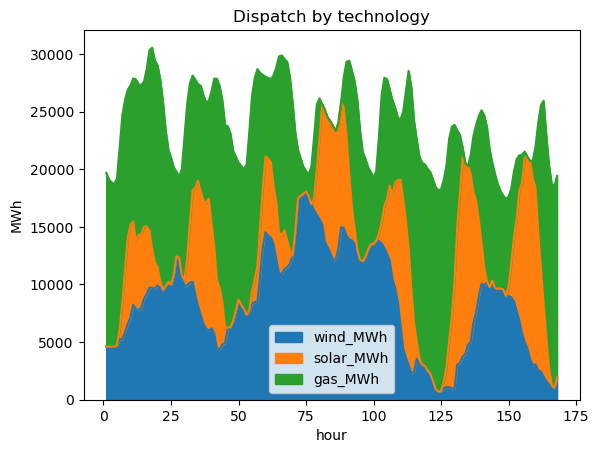

In [51]:
import matplotlib.pyplot as plt

mix[["wind_MWh","solar_MWh","gas_MWh"]].plot(kind="area")
plt.xlabel("hour")
plt.ylabel("MWh")
plt.title("Dispatch by technology")
plt.show()

### Percentage Area Plot 
This plot shows the dispatch by technology as a percentage of the demand. Unserved demand is shown as well.

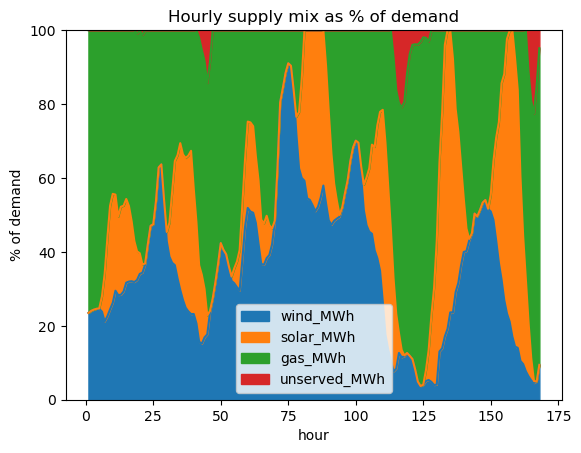

In [54]:
den = mix["demand_MWh"].replace(0, pd.NA)

mix_pct_demand = (mix[["wind_MWh","solar_MWh","gas_MWh","unserved_MWh"]].div(den, axis=0) * 100).fillna(0.0)

ax = mix_pct_demand.plot(kind="area")
ax.set_xlabel("hour")
ax.set_ylabel("% of demand")
ax.set_title("Hourly supply mix as % of demand")
ax.set_ylim(0, 100)
plt.show()


### Percentage Line Graph

This plot shows the dispatch percentage of each technology by the hour as a percentage of the total dispatch (NOT DEMAND). It gives a breakdown of what technology was dispatched each hour and the makeup of supply dispatched. It gives a good visual indicator of which tech is providing the most/least supply by the hour. The "cycles" of solar energy are clearly visible, there is virtually 0 solar production during 0:00 to 4:00 hours of the day.

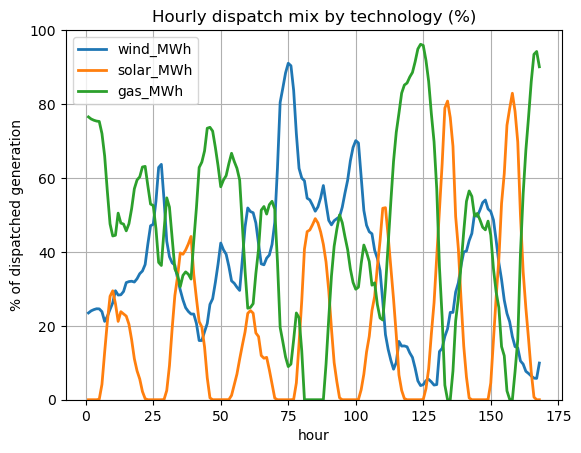

In [57]:
served = mix[["wind_MWh", "solar_MWh", "gas_MWh"]].sum(axis=1).replace(0, pd.NA)

mix_pct = (mix[["wind_MWh", "solar_MWh", "gas_MWh"]].div(served, axis=0) .mul(100) .fillna(0.0))

ax = mix_pct.plot(linewidth=2, grid=True)

ax.set_xlabel("hour")
ax.set_ylabel("% of dispatched generation")
ax.set_title("Hourly dispatch mix by technology (%)")
ax.set_ylim(0, 100)

plt.show()


### Price Graph 

The graph below is a line graph showing the electricity price (marginal price) by the hour. 0 values represent the hours when renewables fully supply the demand. The price fluctuates with the price of the commodity being burnt and the gas plants being used and their respective efficiencies.

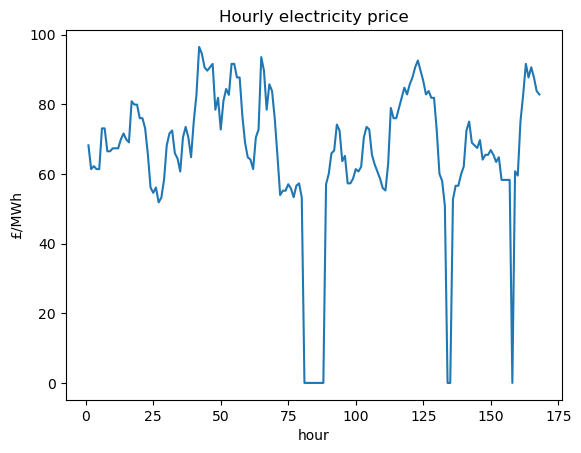

In [25]:
mix["price_£_per_MWh"].plot()
plt.xlabel("hour")
plt.ylabel("£/MWh")
plt.title("Hourly electricity price (Marginal Price")
plt.show()